In [69]:
import numpy as np


In [70]:
def compute_homography(pts1_, pts2_, shape):
    """Compute the homography matrix from 4 point correspondences"""
    # Rescale to actual size
    shape = np.array(shape[::-1], dtype=np.float32)  # different convention [y, x]
    pts1 = pts1_ * np.expand_dims(shape, axis=0)
    pts2 = pts2_ * np.expand_dims(shape, axis=0)

    def ax(p, q):
        return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]

    def ay(p, q):
        return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

    a_mat = np.stack([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)], axis=0)
    p_mat = np.transpose(
        np.stack([[pts2[i][j] for i in range(4) for j in range(2)]], axis=0)
    )
    homography = np.transpose(np.linalg.solve(a_mat, p_mat))
    return flat2mat(homography)

def check_convex(patch, min_convexity=0.05):
    """Checks if given polygon vertices [N,2] form a convex shape"""
    for i in range(patch.shape[0]):
        x1, y1 = patch[(i - 1) % patch.shape[0]]
        x2, y2 = patch[i]
        x3, y3 = patch[(i + 1) % patch.shape[0]]
        if (x2 - x1) * (y3 - y2) - (x3 - x2) * (y2 - y1) > -min_convexity:
            return False
    return True


def flat2mat(H):
    return np.reshape(np.concatenate([H, np.ones_like(H[:, :1])], axis=1), [3, 3])

def create_center_patch(shape, patch_shape=None):
    if patch_shape is None:
        patch_shape = shape
    width, height = shape
    pwidth, pheight = patch_shape
    left = int((width - pwidth) / 2)
    bottom = int((height - pheight) / 2)
    right = int((width + pwidth) / 2)
    top = int((height + pheight) / 2)
    return np.array([[left, bottom], [left, top], [right, top], [right, bottom]])

def sample_homography_corners(
    shape,
    patch_shape,
    difficulty=1.0,
    translation=0.4,
    n_angles=10,
    max_angle=90,
    min_convexity=0.05,
    rng=np.random,
):
    max_angle = max_angle / 180.0 * math.pi
    width, height = shape
    pwidth, pheight = width * (1 - difficulty), height * (1 - difficulty)
    min_pts1 = create_center_patch(shape, (pwidth, pheight))
    full = create_center_patch(shape)
    pts2 = create_center_patch(patch_shape)
    scale = min_pts1 - full
    found_valid = False
    cnt = -1
    while not found_valid:
        offsets = rng.uniform(0.0, 1.0, size=(4, 2)) * scale
        pts1 = full + offsets
        found_valid = check_convex(pts1 / np.array(shape), min_convexity)
        cnt += 1

    # re-center
    pts1 = pts1 - np.mean(pts1, axis=0, keepdims=True)
    pts1 = pts1 + np.mean(min_pts1, axis=0, keepdims=True)

    # Rotation
    if n_angles > 0 and difficulty > 0:
        angles = np.linspace(-max_angle * difficulty, max_angle * difficulty, n_angles)
        rng.shuffle(angles)
        rng.shuffle(angles)
        angles = np.concatenate([[0.0], angles], axis=0)

        center = np.mean(pts1, axis=0, keepdims=True)
        rot_mat = np.reshape(
            np.stack(
                [np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)],
                axis=1,
            ),
            [-1, 2, 2],
        )
        rotated = (
            np.matmul(
                np.tile(np.expand_dims(pts1 - center, axis=0), [n_angles + 1, 1, 1]),
                rot_mat,
            )
            + center
        )

        for idx in range(1, n_angles):
            warped_points = rotated[idx] / np.array(shape)
            if np.all((warped_points >= 0.0) & (warped_points < 1.0)):
                pts1 = rotated[idx]
                break

    # Translation
    if translation > 0:
        min_trans = -np.min(pts1, axis=0)
        max_trans = shape - np.max(pts1, axis=0)
        trans = rng.uniform(min_trans, max_trans)[None]
        pts1 += trans * translation * difficulty

    H = compute_homography(pts1, pts2, [1.0, 1.0])
    warped = warp_points(full, H, inverse=False)
    return H, full, warped, patch_shape


def warp_points(points, homography, inverse=True):
    """
    Warp a list of points with the INVERSE of the given homography.
    The inverse is used to be coherent with tf.contrib.image.transform
    Arguments:
        points: list of N points, shape (N, 2).
        homography: batched or not (shapes (B, 3, 3) and (3, 3) respectively).
    Returns: a Tensor of shape (N, 2) or (B, N, 2) (depending on whether the homography
            is batched) containing the new coordinates of the warped points.
    """
    H = homography[None] if len(homography.shape) == 2 else homography

    # Get the points to the homogeneous format
    num_points = points.shape[0]
    # points = points.astype(np.float32)[:, ::-1]
    points = np.concatenate([points, np.ones([num_points, 1], dtype=np.float32)], -1)

    H_inv = np.transpose(np.linalg.inv(H) if inverse else H)
    warped_points = np.tensordot(points, H_inv, axes=[[1], [0]])

    warped_points = np.transpose(warped_points, [2, 0, 1])
    warped_points[np.abs(warped_points[:, :, 2]) < 1e-8, 2] = 1e-8
    warped_points = warped_points[:, :, :2] / warped_points[:, :, 2:]

    return warped_points[0] if len(homography.shape) == 2 else warped_points



In [71]:
"""BaseModel
Base class for trainable models.
"""

from abc import ABCMeta, abstractmethod
from copy import copy

import omegaconf
from omegaconf import OmegaConf
from torch import nn


class MetaModel(ABCMeta):
    def __prepare__(name, bases, **kwds):
        total_conf = OmegaConf.create()
        for base in bases:
            for key in ("base_default_conf", "default_conf"):
                update = getattr(base, key, {})
                if isinstance(update, dict):
                    update = OmegaConf.create(update)
                total_conf = OmegaConf.merge(total_conf, update)
        return dict(base_default_conf=total_conf)


class BaseModel(nn.Module, metaclass=MetaModel):
    """
    What the child model is expect to declare:
        default_conf: dictionary of the default configuration of the model.
        It recursively updates the default_conf of all parent classes, and
        it is updated by the user-provided configuration passed to __init__.
        Configurations can be nested.

        required_data_keys: list of expected keys in the input data dictionary.

        strict_conf (optional): boolean. If false, BaseModel does not raise
        an error when the user provides an unknown configuration entry.

        _init(self, conf): initialization method, where conf is the final
        configuration object (also accessible with `self.conf`). Accessing
        unknown configuration entries will raise an error.

        _forward(self, data): method that returns a dictionary of batched
        prediction tensors based on a dictionary of batched input data tensors.

        loss(self, pred, data): method that returns a dictionary of losses,
        computed from model predictions and input data. Each loss is a batch
        of scalars, i.e. a torch.Tensor of shape (B,).
        The total loss to be optimized has the key `'total'`.

        metrics(self, pred, data): method that returns a dictionary of metrics,
        each as a batch of scalars.
    """

    default_conf = {
        "name": None,
        "trainable": True,  # if false: do not optimize this model parameters
        "freeze_batch_normalization": False,  # use test-time statistics
        "timeit": False,  # time forward pass
    }
    required_data_keys = []
    strict_conf = False

    are_weights_initialized = False

    def __init__(self, conf):
        """Perform some logic and call the _init method of the child model."""
        super().__init__()
        default_conf = OmegaConf.merge(
            self.base_default_conf, OmegaConf.create(self.default_conf)
        )
        if self.strict_conf:
            OmegaConf.set_struct(default_conf, True)

        # fixme: backward compatibility
        if "pad" in conf and "pad" not in default_conf:  # backward compat.
            with omegaconf.read_write(conf):
                with omegaconf.open_dict(conf):
                    conf["interpolation"] = {"pad": conf.pop("pad")}

        if isinstance(conf, dict):
            conf = OmegaConf.create(conf)
        self.conf = conf = OmegaConf.merge(default_conf, conf)
        OmegaConf.set_readonly(conf, True)
        OmegaConf.set_struct(conf, True)
        self.required_data_keys = copy(self.required_data_keys)
        self._init(conf)

        if not conf.trainable:
            for p in self.parameters():
                p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)

        def freeze_bn(module):
            if isinstance(module, nn.modules.batchnorm._BatchNorm):
                module.eval()

        if self.conf.freeze_batch_normalization:
            self.apply(freeze_bn)

        return self

    def forward(self, data):
        """Check the data and call the _forward method of the child model."""

        def recursive_key_check(expected, given):
            for key in expected:
                assert key in given, f"Missing key {key} in data"
                if isinstance(expected, dict):
                    recursive_key_check(expected[key], given[key])

        recursive_key_check(self.required_data_keys, data)
        return self._forward(data)

    @abstractmethod
    def _init(self, conf):
        """To be implemented by the child class."""
        raise NotImplementedError

    @abstractmethod
    def _forward(self, data):
        """To be implemented by the child class."""
        raise NotImplementedError

    @abstractmethod
    def loss(self, pred, data):
        """To be implemented by the child class."""
        raise NotImplementedError

    def load_state_dict(self, *args, **kwargs):
        """Load the state dict of the model, and set the model to initialized."""
        ret = super().load_state_dict(*args, **kwargs)
        self.set_initialized()
        return ret

    def is_initialized(self):
        """Recursively check if the model is initialized, i.e. weights are loaded"""
        is_initialized = True  # initialize to true and perform recursive and
        for _, w in self.named_children():
            if isinstance(w, BaseModel):
                # if children is BaseModel, we perform recursive check
                is_initialized = is_initialized and w.is_initialized()
            else:
                # else, we check if self is initialized or the children has no params
                n_params = len(list(w.parameters()))
                is_initialized = is_initialized and (
                    n_params == 0 or self.are_weights_initialized
                )
        return is_initialized

    def set_initialized(self, to: bool = True):
        """Recursively set the initialization state."""
        self.are_weights_initialized = to
        for _, w in self.named_parameters():
            if isinstance(w, BaseModel):
                w.set_initialized(to)


In [72]:

def pad_local_features(pred: dict, seq_l: int):
    pred["keypoints"] = pad_to_length(
        pred["keypoints"],
        seq_l,
        -2,
        mode="random_c",
    )
    if "keypoint_scores" in pred.keys():
        pred["keypoint_scores"] = pad_to_length(
            pred["keypoint_scores"], seq_l, -1, mode="zeros"
        )
    if "descriptors" in pred.keys():
        pred["descriptors"] = pad_to_length(
            pred["descriptors"], seq_l, -2, mode="random"
        )
    if "scales" in pred.keys():
        pred["scales"] = pad_to_length(pred["scales"], seq_l, -1, mode="zeros")
    if "oris" in pred.keys():
        pred["oris"] = pad_to_length(pred["oris"], seq_l, -1, mode="zeros")

    if "depth_keypoints" in pred.keys():
        pred["depth_keypoints"] = pad_to_length(
            pred["depth_keypoints"], seq_l, -1, mode="zeros"
        )
    if "valid_depth_keypoints" in pred.keys():
        pred["valid_depth_keypoints"] = pad_to_length(
            pred["valid_depth_keypoints"], seq_l, -1, mode="zeros"
        )
    return pred


def pad_line_features(pred, seq_l: int = None):
    raise NotImplementedError


def recursive_load(grp, pkeys):
    return {
        k: (
            torch.from_numpy(grp[k].__array__())
            if isinstance(grp[k], h5py.Dataset)
            else recursive_load(grp[k], list(grp.keys()))
        )
        for k in pkeys
    }


class CacheLoader(BaseModel):
    default_conf = {
        "path": "???",  # can be a format string like exports/{scene}/
        "data_keys": None,  # load all keys
        "device": None,  # load to same device as data
        "trainable": False,
        "add_data_path": True,
        "collate": True,
        "scale": ["keypoints", "lines", "orig_lines"],
        "padding_fn": None,
        "padding_length": None,  # required for batching!
        "numeric_type": "float32",  # [None, "float16", "float32", "float64"]
    }

    required_data_keys = ["name"]  # we need an identifier

    def _init(self, conf):
        self.hfiles = {}
        self.padding_fn = conf.padding_fn
        if self.padding_fn is not None:
            self.padding_fn = eval(self.padding_fn)
        self.numeric_dtype = {
            None: None,
            "float16": torch.float16,
            "float32": torch.float32,
            "float64": torch.float64,
        }[conf.numeric_type]

    def _forward(self, data):
        preds = []
        device = self.conf.device
        if not device:
            devices = set(
                [v.device for v in data.values() if isinstance(v, torch.Tensor)]
            )
            if len(devices) == 0:
                device = "cpu"
            else:
                assert len(devices) == 1
                device = devices.pop()

        var_names = [x[1] for x in string.Formatter().parse(self.conf.path) if x[1]]
        for i, name in enumerate(data["name"]):
            fpath = self.conf.path.format(**{k: data[k][i] for k in var_names})
            if self.conf.add_data_path:
                fpath = DATA_PATH / fpath
            hfile = h5py.File(str(fpath), "r")
            grp = hfile[name]
            pkeys = (
                self.conf.data_keys if self.conf.data_keys is not None else grp.keys()
            )
            pred = recursive_load(grp, pkeys)
            if self.numeric_dtype is not None:
                pred = {
                    k: (
                        v
                        if not isinstance(v, torch.Tensor)
                        or not torch.is_floating_point(v)
                        else v.to(dtype=self.numeric_dtype)
                    )
                    for k, v in pred.items()
                }
            pred = batch_to_device(pred, device)
            for k, v in pred.items():
                for pattern in self.conf.scale:
                    if k.startswith(pattern):
                        view_idx = k.replace(pattern, "")
                        scales = (
                            data["scales"]
                            if len(view_idx) == 0
                            else data[f"view{view_idx}"]["scales"]
                        )
                        pred[k] = pred[k] * scales[i]
            # use this function to fix number of keypoints etc.
            if self.padding_fn is not None:
                pred = self.padding_fn(pred, self.conf.padding_length)
            preds.append(pred)
            hfile.close()
        if self.conf.collate:
            return batch_to_device(collate(preds), device)
        else:
            assert len(preds) == 1
            return batch_to_device(preds[0], device)

    def loss(self, pred, data):
        raise NotImplementedError


In [73]:
from pathlib import Path
import os

# root = Path(__file__).parent.parent  # top-level directory
root = Path(os.getcwd()).parent  # top-level directory

DATA_PATH = root / "data/"  # datasets and pretrained weights
TRAINING_PATH = root / "outputs/training/"  # training checkpoints
EVAL_PATH = root / "outputs/results/"  # evaluation results


In [74]:
def read_image(path: Path, grayscale: bool = False) -> np.ndarray:
    """Read an image from path as RGB or grayscale"""
    if not Path(path).exists():
        raise FileNotFoundError(f"No image at path {path}.")
    mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(str(path), mode)
    if image is None:
        raise IOError(f"Could not read image at {path}.")
    if not grayscale:
        image = image[..., ::-1]
    return image


In [75]:
from contextlib import contextmanager
@contextmanager
def fork_rng(seed=None, with_cuda=True):
    state = get_random_state(with_cuda)
    if seed is not None:
        set_seed(seed)
    try:
        yield
    finally:
        set_random_state(state)


In [76]:

def plot_image_grid(
    imgs,
    titles=None,
    cmaps="gray",
    dpi=100,
    pad=0.5,
    fig=None,
    adaptive=True,
    figs=2.0,
    return_fig=False,
    set_lim=False,
):
    """Plot a grid of images.
    Args:
        imgs: a list of lists of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
        adaptive: whether the figure size should fit the image aspect ratios.
    """
    nr, n = len(imgs), len(imgs[0])
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n

    if adaptive:
        ratios = [i.shape[1] / i.shape[0] for i in imgs[0]]  # W / H
    else:
        ratios = [4 / 3] * n

    figsize = [sum(ratios) * figs, nr * figs]
    if fig is None:
        fig, axs = plt.subplots(
            nr, n, figsize=figsize, dpi=dpi, gridspec_kw={"width_ratios": ratios}
        )
    else:
        axs = fig.subplots(nr, n, gridspec_kw={"width_ratios": ratios})
        fig.figure.set_size_inches(figsize)
    if nr == 1:
        axs = [axs]

    for j in range(nr):
        for i in range(n):
            ax = axs[j][i]
            ax.imshow(imgs[j][i], cmap=plt.get_cmap(cmaps[i]))
            ax.set_axis_off()
            if set_lim:
                ax.set_xlim([0, imgs[j][i].shape[1]])
                ax.set_ylim([imgs[j][i].shape[0], 0])
            if titles:
                ax.set_title(titles[j][i])
    if isinstance(fig, plt.Figure):
        fig.tight_layout(pad=pad)
    if return_fig:
        return fig, axs
    else:
        return axs


In [77]:
from typing import Union

import albumentations as A
import cv2
import numpy as np
import torch
from albumentations.pytorch.transforms import ToTensorV2
from omegaconf import OmegaConf


class IdentityTransform(A.ImageOnlyTransform):
    def apply(self, img, **params):
        return img

    def get_transform_init_args_names(self):
        return ()


class RandomAdditiveShade(A.ImageOnlyTransform):
    def __init__(
        self,
        nb_ellipses=10,
        transparency_limit=[-0.5, 0.8],
        kernel_size_limit=[150, 350],
        always_apply=False,
        p=0.5,
    ):
        super().__init__(always_apply, p)
        self.nb_ellipses = nb_ellipses
        self.transparency_limit = transparency_limit
        self.kernel_size_limit = kernel_size_limit

    def apply(self, img, **params):
        if img.dtype == np.float32:
            shaded = self._py_additive_shade(img * 255.0)
            shaded /= 255.0
        elif img.dtype == np.uint8:
            shaded = self._py_additive_shade(img.astype(np.float32))
            shaded = shaded.astype(np.uint8)
        else:
            raise NotImplementedError(
                f"Data augmentation not available for type: {img.dtype}"
            )
        return shaded

    def _py_additive_shade(self, img):
        grayscale = len(img.shape) == 2
        if grayscale:
            img = img[None]
        min_dim = min(img.shape[:2]) / 4
        mask = np.zeros(img.shape[:2], img.dtype)
        for i in range(self.nb_ellipses):
            ax = int(max(np.random.rand() * min_dim, min_dim / 5))
            ay = int(max(np.random.rand() * min_dim, min_dim / 5))
            max_rad = max(ax, ay)
            x = np.random.randint(max_rad, img.shape[1] - max_rad)  # center
            y = np.random.randint(max_rad, img.shape[0] - max_rad)
            angle = np.random.rand() * 90
            cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)

        transparency = np.random.uniform(*self.transparency_limit)
        ks = np.random.randint(*self.kernel_size_limit)
        if (ks % 2) == 0:  # kernel_size has to be odd
            ks += 1
        mask = cv2.GaussianBlur(mask.astype(np.float32), (ks, ks), 0)
        shaded = img * (1 - transparency * mask[..., np.newaxis] / 255.0)
        out = np.clip(shaded, 0, 255)
        if grayscale:
            out = out.squeeze(0)
        return out

    def get_transform_init_args_names(self):
        return "transparency_limit", "kernel_size_limit", "nb_ellipses"


def kw(entry: Union[float, dict], n=None, **default):
    if not isinstance(entry, dict):
        entry = {"p": entry}
    entry = OmegaConf.create(entry)
    if n is not None:
        entry = default.get(n, entry)
    return OmegaConf.merge(default, entry)


def kwi(entry: Union[float, dict], n=None, **default):
    conf = kw(entry, n=n, **default)
    return {k: conf[k] for k in set(default.keys()).union(set(["p"]))}


def replay_str(transforms, s="Replay:\n", log_inactive=True):
    for t in transforms:
        if "transforms" in t.keys():
            s = replay_str(t["transforms"], s=s)
        elif t["applied"] or log_inactive:
            s += t["__class_fullname__"] + " " + str(t["applied"]) + "\n"
    return s


class BaseAugmentation(object):
    base_default_conf = {
        "name": "???",
        "shuffle": False,
        "p": 1.0,
        "verbose": False,
        "dtype": "uint8",  # (byte, float)
    }

    default_conf = {}

    def __init__(self, conf={}):
        """Perform some logic and call the _init method of the child model."""
        default_conf = OmegaConf.merge(
            OmegaConf.create(self.base_default_conf),
            OmegaConf.create(self.default_conf),
        )
        OmegaConf.set_struct(default_conf, True)
        if isinstance(conf, dict):
            conf = OmegaConf.create(conf)
        self.conf = OmegaConf.merge(default_conf, conf)
        OmegaConf.set_readonly(self.conf, True)
        self._init(self.conf)

        self.conf = OmegaConf.merge(self.conf, conf)
        if self.conf.verbose:
            self.compose = A.ReplayCompose
        else:
            self.compose = A.Compose
        if self.conf.dtype == "uint8":
            self.dtype = np.uint8
            self.preprocess = A.FromFloat(always_apply=True, dtype="uint8")
            self.postprocess = A.ToFloat(always_apply=True)
        elif self.conf.dtype == "float32":
            self.dtype = np.float32
            self.preprocess = A.ToFloat(always_apply=True)
            self.postprocess = IdentityTransform()
        else:
            raise ValueError(f"Unsupported dtype {self.conf.dtype}")
        self.to_tensor = ToTensorV2()

    def _init(self, conf):
        """Child class overwrites this, setting up a list of transforms"""
        self.transforms = []

    def __call__(self, image, return_tensor=False):
        """image as HW or HWC"""
        if isinstance(image, torch.Tensor):
            image = image.cpu().detach().numpy()
        data = {"image": image}
        if image.dtype != self.dtype:
            data = self.preprocess(**data)
        transforms = self.transforms
        if self.conf.shuffle:
            order = [i for i, _ in enumerate(transforms)]
            np.random.shuffle(order)
            transforms = [transforms[i] for i in order]
        transformed = self.compose(transforms, p=self.conf.p)(**data)
        if self.conf.verbose:
            print(replay_str(transformed["replay"]["transforms"]))
        transformed = self.postprocess(**transformed)
        if return_tensor:
            return self.to_tensor(**transformed)["image"]
        else:
            return transformed["image"]


class IdentityAugmentation(BaseAugmentation):
    default_conf = {}

    def _init(self, conf):
        self.transforms = [IdentityTransform(p=1.0)]


class DarkAugmentation(BaseAugmentation):
    default_conf = {"p": 0.75}

    def _init(self, conf):
        bright_contr = 0.5
        blur = 0.1
        random_gamma = 0.1
        hue = 0.1
        self.transforms = [
            A.RandomRain(p=0.2),
            A.RandomBrightnessContrast(
                **kw(
                    bright_contr,
                    brightness_limit=(-0.4, 0.0),
                    contrast_limit=(-0.3, 0.0),
                )
            ),
            A.OneOf(
                [
                    A.Blur(**kwi(blur, p=0.1, blur_limit=(3, 9), n="blur")),
                    A.MotionBlur(
                        **kwi(
                            blur,
                            p=0.2,
                            blur_limit=(3, 25),
                            allow_shifted=False,
                            n="motion_blur",
                        )
                    ),
                    A.ISONoise(),
                    A.ImageCompression(),
                ],
                **kwi(blur, p=0.1),
            ),
            A.RandomGamma(**kw(random_gamma, gamma_limit=(15, 65))),
            A.OneOf(
                [
                    A.Equalize(),
                    A.CLAHE(p=0.2),
                    A.ToGray(),
                    A.ToSepia(p=0.1),
                    A.HueSaturationValue(**kw(hue, val_shift_limit=(-100, -40))),
                ],
                p=0.5,
            ),
        ]


class LGAugmentation(BaseAugmentation):
    default_conf = {"p": 0.95}

    def _init(self, conf):
        self.transforms = [
            A.RandomGamma(p=0.1, gamma_limit=(15, 65)),
            A.HueSaturationValue(p=0.1, val_shift_limit=(-100, -40)),
            A.OneOf(
                [
                    A.Blur(blur_limit=(3, 9)),
                    A.MotionBlur(blur_limit=(3, 25), allow_shifted=False),
                    A.ISONoise(),
                    A.ImageCompression(),
                ],
                p=0.1,
            ),
            A.Blur(p=0.1, blur_limit=(3, 9)),
            A.MotionBlur(p=0.1, blur_limit=(3, 25), allow_shifted=False),
            A.RandomBrightnessContrast(
                p=0.5, brightness_limit=(-0.4, 0.0), contrast_limit=(-0.3, 0.0)
            ),
            A.CLAHE(p=0.2),
        ]


augmentations = {
    "dark": DarkAugmentation,
    "lg": LGAugmentation,
    "identity": IdentityAugmentation,
}



In [78]:

class BaseDataset(metaclass=ABCMeta):
    """
    What the dataset model is expect to declare:
        default_conf: dictionary of the default configuration of the dataset.
        It overwrites base_default_conf in BaseModel, and it is overwritten by
        the user-provided configuration passed to __init__.
        Configurations can be nested.

        _init(self, conf): initialization method, where conf is the final
        configuration object (also accessible with `self.conf`). Accessing
        unknown configuration entries will raise an error.

        get_dataset(self, split): method that returns an instance of
        torch.utils.data.Dataset corresponding to the requested split string,
        which can be `'train'`, `'val'`, or `'test'`.
    """

    base_default_conf = {
        "name": "???",
        "num_workers": "???",
        "train_batch_size": "???",
        "val_batch_size": "???",
        "test_batch_size": "???",
        "shuffle_training": True,
        "batch_size": 1,
        "num_threads": 1,
        "seed": 0,
        "prefetch_factor": 2,
    }
    default_conf = {}

    def __init__(self, conf):
        """Perform some logic and call the _init method of the child model."""
        default_conf = OmegaConf.merge(
            OmegaConf.create(self.base_default_conf),
            OmegaConf.create(self.default_conf),
        )
        OmegaConf.set_struct(default_conf, True)
        if isinstance(conf, dict):
            conf = OmegaConf.create(conf)
        self.conf = OmegaConf.merge(default_conf, conf)
        OmegaConf.set_readonly(self.conf, True)
        logger.info(f"Creating dataset {self.__class__.__name__}")
        self._init(self.conf)

    @abstractmethod
    def _init(self, conf):
        """To be implemented by the child class."""
        raise NotImplementedError

    @abstractmethod
    def get_dataset(self, split):
        """To be implemented by the child class."""
        raise NotImplementedError

    def get_data_loader(self, split, shuffle=None, pinned=False, distributed=False):
        """Return a data loader for a given split."""
        assert split in ["train", "val", "test"]
        dataset = self.get_dataset(split)
        try:
            batch_size = self.conf[split + "_batch_size"]
        except omegaconf.MissingMandatoryValue:
            batch_size = self.conf.batch_size
        num_workers = self.conf.get("num_workers", batch_size)
        drop_last = True if split == "train" else False
        if distributed:
            shuffle = False
            sampler = torch.utils.data.distributed.DistributedSampler(
                dataset, drop_last=drop_last
            )
        else:
            sampler = None
            if shuffle is None:
                shuffle = split == "train" and self.conf.shuffle_training
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            pin_memory=pinned,
            collate_fn=collate,
            num_workers=num_workers,
            worker_init_fn=worker_init_fn,
            prefetch_factor=self.conf.prefetch_factor,
            drop_last=drop_last,
        )

    def get_overfit_loader(self, split):
        """Return an overfit data loader.
        The training set is composed of a single duplicated batch, while
        the validation and test sets contain a single copy of this same batch.
        This is useful to debug a model and make sure that losses and metrics
        correlate well.
        """
        assert split in ["train", "val", "test"]
        dataset = self.get_dataset("train")
        sampler = LoopSampler(
            self.conf.batch_size,
            len(dataset) if split == "train" else self.conf.batch_size,
        )
        num_workers = self.conf.get("num_workers", self.conf.batch_size)
        return DataLoader(
            dataset,
            batch_size=self.conf.batch_size,
            pin_memory=True,
            num_workers=num_workers,
            sampler=sampler,
            worker_init_fn=worker_init_fn,
            collate_fn=collate,
        )


In [79]:


# from geometry.homography import (     compute_homography,    sample_homography_corners,    warp_points,)

# from ..models.cache_loader import CacheLoader, pad_local_features
#from ..settings import DATA_PATH
#from ..utils.image import read_image
# from ..utils.tools import fork_rng
# from ..visualization.viz2d import plot_image_grid
#from .augmentations import IdentityAugmentation, augmentations
# from .base_dataset import BaseDataset

#logger = logging.getLogger(__name__)


def sample_homography(img, conf: dict, size: list):
    data = {}
    H, _, coords, _ = sample_homography_corners(img.shape[:2][::-1], **conf)
    data["image"] = cv2.warpPerspective(img, H, tuple(size))
    data["H_"] = H.astype(np.float32)
    data["coords"] = coords.astype(np.float32)
    data["image_size"] = np.array(size, dtype=np.float32)
    return data


class HomographyDataset(BaseDataset):
    default_conf = {
        # image search
        "data_dir": "revisitop1m",  # the top-level directory
        "image_dir": "jpg/",  # the subdirectory with the images
        "image_list": "revisitop1m.txt",  # optional: list or filename of list
        "glob": ["*.jpg", "*.png", "*.jpeg", "*.JPG", "*.PNG"],
        # splits
        "train_size": 100,
        "val_size": 10,
        "shuffle_seed": 0,  # or None to skip
        # image loading
        "grayscale": False,
        "triplet": False,
        "right_only": False,  # image0 is orig (rescaled), image1 is right
        "reseed": False,
        "homography": {
            "difficulty": 0.8,
            "translation": 1.0,
            "max_angle": 60,
            "n_angles": 10,
            "patch_shape": [640, 480],
            "min_convexity": 0.05,
        },
        "photometric": {
            "name": "dark",
            "p": 0.75,
            # 'difficulty': 1.0,  # currently unused
        },
        # feature loading
        "load_features": {
            "do": False,
            **CacheLoader.default_conf,
            "collate": False,
            "thresh": 0.0,
            "max_num_keypoints": -1,
            "force_num_keypoints": False,
        },
    }

    def _init(self, conf):
        data_dir = DATA_PATH / conf.data_dir
        if not data_dir.exists():
            if conf.data_dir == "revisitop1m":
                logger.info("Downloading the revisitop1m dataset.")
                self.download_revisitop1m()
            else:
                raise FileNotFoundError(data_dir)

        image_dir = data_dir / conf.image_dir
        images = []
        if conf.image_list is None:
            glob = [conf.glob] if isinstance(conf.glob, str) else conf.glob
            for g in glob:
                images += list(image_dir.glob("**/" + g))
            if len(images) == 0:
                raise ValueError(f"Cannot find any image in folder: {image_dir}.")
            images = [i.relative_to(image_dir).as_posix() for i in images]
            images = sorted(images)  # for deterministic behavior
            logger.info("Found %d images in folder.", len(images))
        elif isinstance(conf.image_list, (str, Path)):
            image_list = data_dir / conf.image_list
            if not image_list.exists():
                raise FileNotFoundError(f"Cannot find image list {image_list}.")
            images = image_list.read_text().rstrip("\n").split("\n")
            for image in images:
                if not (image_dir / image).exists():
                    raise FileNotFoundError(image_dir / image)
            logger.info("Found %d images in list file.", len(images))
        elif isinstance(conf.image_list, omegaconf.listconfig.ListConfig):
            images = conf.image_list.to_container()
            for image in images:
                if not (image_dir / image).exists():
                    raise FileNotFoundError(image_dir / image)
        else:
            raise ValueError(conf.image_list)

        if conf.shuffle_seed is not None:
            np.random.RandomState(conf.shuffle_seed).shuffle(images)
        train_images = images[: conf.train_size]
        val_images = images[conf.train_size : conf.train_size + conf.val_size]
        self.images = {"train": train_images, "val": val_images}

    def download_revisitop1m(self):
        data_dir = DATA_PATH / self.conf.data_dir
        tmp_dir = data_dir.parent / "revisitop1m_tmp"
        if tmp_dir.exists():  # The previous download failed.
            shutil.rmtree(tmp_dir)
        image_dir = tmp_dir / self.conf.image_dir
        image_dir.mkdir(exist_ok=True, parents=True)
        num_files = 100
        url_base = "http://ptak.felk.cvut.cz/revisitop/revisitop1m/"
        list_name = "revisitop1m.txt"
        torch.hub.download_url_to_file(url_base + list_name, tmp_dir / list_name)
        for n in tqdm(range(num_files), position=1):
            tar_name = "revisitop1m.{}.tar.gz".format(n + 1)
            tar_path = image_dir / tar_name
            torch.hub.download_url_to_file(url_base + "jpg/" + tar_name, tar_path)
            with tarfile.open(tar_path) as tar:
                tar.extractall(path=image_dir)
            tar_path.unlink()
        shutil.move(tmp_dir, data_dir)

    def get_dataset(self, split):
        return _Dataset(self.conf, self.images[split], split)


class _Dataset(torch.utils.data.Dataset):
    def __init__(self, conf, image_names, split):
        self.conf = conf
        self.split = split
        self.image_names = np.array(image_names)
        self.image_dir = DATA_PATH / conf.data_dir / conf.image_dir

        aug_conf = conf.photometric
        aug_name = aug_conf.name
        assert (
            aug_name in augmentations.keys()
        ), f'{aug_name} not in {" ".join(augmentations.keys())}'
        self.photo_augment = augmentations[aug_name](aug_conf)
        self.left_augment = (
            IdentityAugmentation() if conf.right_only else self.photo_augment
        )
        self.img_to_tensor = IdentityAugmentation()

        if conf.load_features.do:
            self.feature_loader = CacheLoader(conf.load_features)

    def _transform_keypoints(self, features, data):
        """Transform keypoints by a homography, threshold them,
        and potentially keep only the best ones."""
        # Warp points
        features["keypoints"] = warp_points(
            features["keypoints"], data["H_"], inverse=False
        )
        h, w = data["image"].shape[1:3]
        valid = (
            (features["keypoints"][:, 0] >= 0)
            & (features["keypoints"][:, 0] <= w - 1)
            & (features["keypoints"][:, 1] >= 0)
            & (features["keypoints"][:, 1] <= h - 1)
        )
        features["keypoints"] = features["keypoints"][valid]

        # Threshold
        if self.conf.load_features.thresh > 0:
            valid = features["keypoint_scores"] >= self.conf.load_features.thresh
            features = {k: v[valid] for k, v in features.items()}

        # Get the top keypoints and pad
        n = self.conf.load_features.max_num_keypoints
        if n > -1:
            inds = np.argsort(-features["keypoint_scores"])
            features = {k: v[inds[:n]] for k, v in features.items()}

            if self.conf.load_features.force_num_keypoints:
                features = pad_local_features(
                    features, self.conf.load_features.max_num_keypoints
                )

        return features

    def __getitem__(self, idx):
        if self.conf.reseed:
            with fork_rng(self.conf.seed + idx, False):
                return self.getitem(idx)
        else:
            return self.getitem(idx)

    def _read_view(self, img, H_conf, ps, left=False):
        data = sample_homography(img, H_conf, ps)
        if left:
            data["image"] = self.left_augment(data["image"], return_tensor=True)
        else:
            data["image"] = self.photo_augment(data["image"], return_tensor=True)

        gs = data["image"].new_tensor([0.299, 0.587, 0.114]).view(3, 1, 1)
        if self.conf.grayscale:
            data["image"] = (data["image"] * gs).sum(0, keepdim=True)

        if self.conf.load_features.do:
            features = self.feature_loader({k: [v] for k, v in data.items()})
            features = self._transform_keypoints(features, data)
            data["cache"] = features

        return data

    def getitem(self, idx):
        name = self.image_names[idx]
        img = read_image(self.image_dir / name, False)
        if img is None:
            logging.warning("Image %s could not be read.", name)
            img = np.zeros((1024, 1024) + (() if self.conf.grayscale else (3,)))
        img = img.astype(np.float32) / 255.0
        size = img.shape[:2][::-1]
        ps = self.conf.homography.patch_shape

        left_conf = omegaconf.OmegaConf.to_container(self.conf.homography)
        if self.conf.right_only:
            left_conf["difficulty"] = 0.0

        data0 = self._read_view(img, left_conf, ps, left=True)
        data1 = self._read_view(img, self.conf.homography, ps, left=False)

        H = compute_homography(data0["coords"], data1["coords"], [1, 1])

        data = {
            "name": name,
            "original_image_size": np.array(size),
            "H_0to1": H.astype(np.float32),
            "idx": idx,
            "view0": data0,
            "view1": data1,
        }

        if self.conf.triplet:
            # Generate third image
            data2 = self._read_view(img, self.conf.homography, ps, left=False)
            H02 = compute_homography(data0["coords"], data2["coords"], [1, 1])
            H12 = compute_homography(data1["coords"], data2["coords"], [1, 1])

            data = {
                "H_0to2": H02.astype(np.float32),
                "H_1to2": H12.astype(np.float32),
                "view2": data2,
                **data,
            }

        return data

    def __len__(self):
        return len(self.image_names)


def visualize(args):
    conf = {
        "batch_size": 1,
        "num_workers": 1,
        "prefetch_factor": 1,
    }
    conf = OmegaConf.merge(conf, OmegaConf.from_cli(args.dotlist))
    dataset = HomographyDataset(conf)
    loader = dataset.get_data_loader("train")
    logger.info("The dataset has %d elements.", len(loader))

    with fork_rng(seed=dataset.conf.seed):
        images = []
        for _, data in zip(range(args.num_items), loader):
            images.append(
                [data[f"view{i}"]["image"][0].permute(1, 2, 0) for i in range(2)]
            )
    plot_image_grid(images, dpi=args.dpi)
    plt.tight_layout()
    plt.show()




In [80]:
import math
from typing import List, Optional, Tuple

import torch


def to_sequence(map):
    return map.flatten(-2).transpose(-1, -2)


def to_map(sequence):
    n = sequence.shape[-2]
    e = math.isqrt(n)
    assert e * e == n
    assert e * e == n
    sequence.transpose(-1, -2).unflatten(-1, [e, e])


def pad_to_length(
    x,
    length: int,
    pad_dim: int = -2,
    mode: str = "zeros",  # zeros, ones, random, random_c
    bounds: Tuple[int] = (None, None),
):
    shape = list(x.shape)
    d = x.shape[pad_dim]
    assert d <= length
    if d == length:
        return x
    shape[pad_dim] = length - d

    low, high = bounds

    if mode == "zeros":
        xn = torch.zeros(*shape, device=x.device, dtype=x.dtype)
    elif mode == "ones":
        xn = torch.ones(*shape, device=x.device, dtype=x.dtype)
    elif mode == "random":
        low = low if low is not None else x.min()
        high = high if high is not None else x.max()
        xn = torch.empty(*shape, device=x.device).uniform_(low, high)
    elif mode == "random_c":
        low, high = bounds  # we use the bounds as fallback for empty seq.
        xn = torch.cat(
            [
                torch.empty(*shape[:-1], 1, device=x.device).uniform_(
                    x[..., i].min() if d > 0 else low,
                    x[..., i].max() if d > 0 else high,
                )
                for i in range(shape[-1])
            ],
            dim=-1,
        )
    else:
        raise ValueError(mode)
    return torch.cat([x, xn], dim=pad_dim)


def pad_and_stack(
    sequences: List[torch.Tensor],
    length: Optional[int] = None,
    pad_dim: int = -2,
    **kwargs,
):
    if length is None:
        length = max([x.shape[pad_dim] for x in sequences])

    y = torch.stack([pad_to_length(x, length, pad_dim, **kwargs) for x in sequences], 0)
    return y

In [81]:
"""PyTorch implementation of the SuperPoint model,
   derived from the TensorFlow re-implementation (2018).
   Authors: Rémi Pautrat, Paul-Edouard Sarlin
   https://github.com/rpautrat/SuperPoint
   The implementation of this model and its trained weights are made
   available under the MIT license.
"""

from collections import OrderedDict
from pathlib import Path
from types import SimpleNamespace

import torch
import torch.nn as nn

#from ..base_model import BaseModel
#from ..utils.misc import pad_and_stack


def sample_descriptors(keypoints, descriptors, s: int = 8):
    """Interpolate descriptors at keypoint locations"""
    b, c, h, w = descriptors.shape
    keypoints = (keypoints + 0.5) / (keypoints.new_tensor([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalize to (-1, 1)
    descriptors = torch.nn.functional.grid_sample(
        descriptors, keypoints.view(b, 1, -1, 2), mode="bilinear", align_corners=False
    )
    descriptors = torch.nn.functional.normalize(
        descriptors.reshape(b, c, -1), p=2, dim=1
    )
    return descriptors


def batched_nms(scores, nms_radius: int):
    assert nms_radius >= 0

    def max_pool(x):
        return torch.nn.functional.max_pool2d(
            x, kernel_size=nms_radius * 2 + 1, stride=1, padding=nms_radius
        )

    zeros = torch.zeros_like(scores)
    max_mask = scores == max_pool(scores)
    for _ in range(2):
        supp_mask = max_pool(max_mask.float()) > 0
        supp_scores = torch.where(supp_mask, zeros, scores)
        new_max_mask = supp_scores == max_pool(supp_scores)
        max_mask = max_mask | (new_max_mask & (~supp_mask))
    return torch.where(max_mask, scores, zeros)


def select_top_k_keypoints(keypoints, scores, k):
    if k >= len(keypoints):
        return keypoints, scores
    scores, indices = torch.topk(scores, k, dim=0, sorted=True)
    return keypoints[indices], scores


class VGGBlock(nn.Sequential):
    def __init__(self, c_in, c_out, kernel_size, relu=True):
        padding = (kernel_size - 1) // 2
        conv = nn.Conv2d(
            c_in, c_out, kernel_size=kernel_size, stride=1, padding=padding
        )
        activation = nn.ReLU(inplace=True) if relu else nn.Identity()
        bn = nn.BatchNorm2d(c_out, eps=0.001)
        super().__init__(
            OrderedDict(
                [
                    ("conv", conv),
                    ("activation", activation),
                    ("bn", bn),
                ]
            )
        )


class SuperPoint(BaseModel):
    default_conf = {
        "descriptor_dim": 256,
        "nms_radius": 4,
        "max_num_keypoints": None,
        "force_num_keypoints": False,
        "detection_threshold": 0.005,
        "remove_borders": 4,
        "descriptor_dim": 256,
        "channels": [64, 64, 128, 128, 256],
        "dense_outputs": None,
        "weights": None,  # local path of pretrained weights
    }

    checkpoint_url = "https://github.com/rpautrat/SuperPoint/raw/master/weights/superpoint_v6_from_tf.pth"  # noqa: E501

    def _init(self, conf):
        self.conf = SimpleNamespace(**conf)
        self.stride = 2 ** (len(self.conf.channels) - 2)
        channels = [1, *self.conf.channels[:-1]]

        backbone = []
        for i, c in enumerate(channels[1:], 1):
            layers = [VGGBlock(channels[i - 1], c, 3), VGGBlock(c, c, 3)]
            if i < len(channels) - 1:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            backbone.append(nn.Sequential(*layers))
        self.backbone = nn.Sequential(*backbone)

        c = self.conf.channels[-1]
        self.detector = nn.Sequential(
            VGGBlock(channels[-1], c, 3),
            VGGBlock(c, self.stride**2 + 1, 1, relu=False),
        )
        self.descriptor = nn.Sequential(
            VGGBlock(channels[-1], c, 3),
            VGGBlock(c, self.conf.descriptor_dim, 1, relu=False),
        )

        if conf.weights is not None and Path(conf.weights).exists():
            state_dict = torch.load(conf.weights, map_location="cpu")
        else:
            state_dict = torch.hub.load_state_dict_from_url(self.checkpoint_url)
        self.load_state_dict(state_dict)

    def _forward(self, data):
        image = data["image"]
        if image.shape[1] == 3:  # RGB
            scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
            image = (image * scale).sum(1, keepdim=True)
        features = self.backbone(image)
        descriptors_dense = torch.nn.functional.normalize(
            self.descriptor(features), p=2, dim=1
        )

        # Decode the detection scores
        scores = self.detector(features)
        scores = torch.nn.functional.softmax(scores, 1)[:, :-1]
        b, _, h, w = scores.shape
        scores = scores.permute(0, 2, 3, 1).reshape(b, h, w, self.stride, self.stride)
        scores = scores.permute(0, 1, 3, 2, 4).reshape(
            b, h * self.stride, w * self.stride
        )
        scores = batched_nms(scores, self.conf.nms_radius)

        # Discard keypoints near the image borders
        if self.conf.remove_borders:
            pad = self.conf.remove_borders
            scores[:, :pad] = -1
            scores[:, :, :pad] = -1
            scores[:, -pad:] = -1
            scores[:, :, -pad:] = -1

        # Extract keypoints
        if b > 1:
            idxs = torch.where(scores > self.conf.detection_threshold)
            mask = idxs[0] == torch.arange(b, device=scores.device)[:, None]
        else:  # Faster shortcut
            scores = scores.squeeze(0)
            idxs = torch.where(scores > self.conf.detection_threshold)

        # Convert (i, j) to (x, y)
        keypoints_all = torch.stack(idxs[-2:], dim=-1).flip(1).float()
        scores_all = scores[idxs]

        keypoints = []
        scores = []
        for i in range(b):
            if b > 1:
                k = keypoints_all[mask[i]]
                s = scores_all[mask[i]]
            else:
                k = keypoints_all
                s = scores_all
            if self.conf.max_num_keypoints is not None:
                k, s = select_top_k_keypoints(k, s, self.conf.max_num_keypoints)

            keypoints.append(k)
            scores.append(s)

        if self.conf.force_num_keypoints:
            keypoints = pad_and_stack(
                keypoints,
                self.conf.max_num_keypoints,
                -2,
                mode="random_c",
                bounds=(
                    0,
                    data.get("image_size", torch.tensor(image.shape[-2:])).min().item(),
                ),
            )
            scores = pad_and_stack(
                scores, self.conf.max_num_keypoints, -1, mode="zeros"
            )
        else:
            keypoints = torch.stack(keypoints, 0)
            scores = torch.stack(scores, 0)

        if len(keypoints) == 1 or self.conf.force_num_keypoints:
            # Batch sampling of the descriptors
            desc = sample_descriptors(keypoints, descriptors_dense, self.stride)
        else:
            desc = [
                sample_descriptors(k[None], d[None], self.stride)[0]
                for k, d in zip(keypoints, descriptors_dense)
            ]

        pred = {
            "keypoints": keypoints + 0.5,
            "keypoint_scores": scores,
            "descriptors": desc.transpose(-1, -2),
        }
        if self.conf.dense_outputs:
            pred["dense_descriptors"] = descriptors_dense

        return pred

    def loss(self, pred, data):
        raise NotImplementedError


In [82]:
def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)


The image size is: 
1306 859


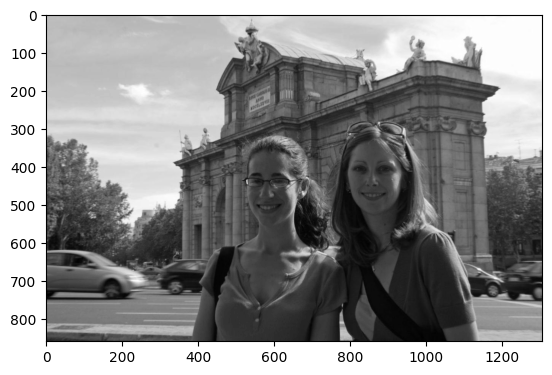

In [83]:
# path = 'data/mini_depth_100'
# image_path = 'data/mini_depth_100/138408872_2f903a81d4_o.jpg'
# generate sample homographies for images in path
from PIL import Image
import math
import cv2
import matplotlib.pyplot as plt

image_path = '/home/egoedeke/OneDrive/ETH/3DVision/glue-factory/data/mini_depth_100/813972011_a3217f7d76_o.jpg'
image = Image.open(image_path)
# convert image to grayscale 

width, height = image.size

# print image dimension
print('The image size is: ')
print(width, height)

#image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

gray = cv2.imread(image_path, 0)

# show gray
plt.imshow(gray, cmap='gray')
plt.show()

In [91]:
image_path1 = '/home/egoedeke/Downloads/MegaDepth_v1/phoenix/S6/zl548/MegaDepth_v1/0000/dense1/imgs/11037727_d36d4462ad_o.jpg'



testHomogrophy = HomographyDataset.default_conf["homography"]

# print the test homography keys
print('The test homography keys are: ')
print(testHomogrophy.keys())



The test homography keys are: 
dict_keys(['difficulty', 'translation', 'max_angle', 'n_angles', 'patch_shape', 'min_convexity'])


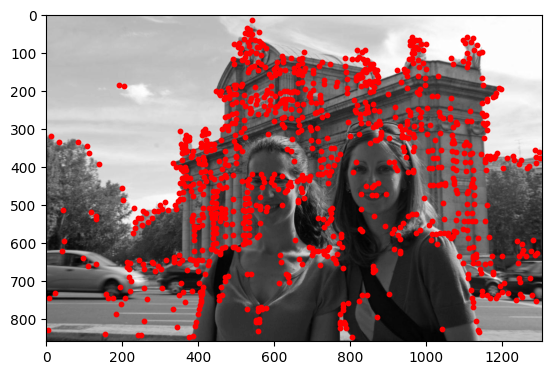

In [85]:

sp_conf = {
    "max_num_keypoints": 1024,
    "nms_radius": 4,
    "detection_threshold": 0.005,
    "remove_borders": 4,
    "descriptor_dim": 256,
    "channels": [64, 64, 128, 128, 256],
    "dense_outputs": None,
    "weights": None,  # local path of pretrained weights
}


model = SuperPoint(sp_conf)
model.eval()
with torch.no_grad():
    # Get predictions from the model
    pred = model({"image": numpy_image_to_torch(gray)[None]})
    # Move predictions to CPU and convert to numpy arrays
    pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
    keypoints = pred["keypoints"]
    scores = pred["keypoint_scores"]
    descriptors = pred["descriptors"]
    
# Show keypoints
plt.imshow(gray, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=10, c='r')


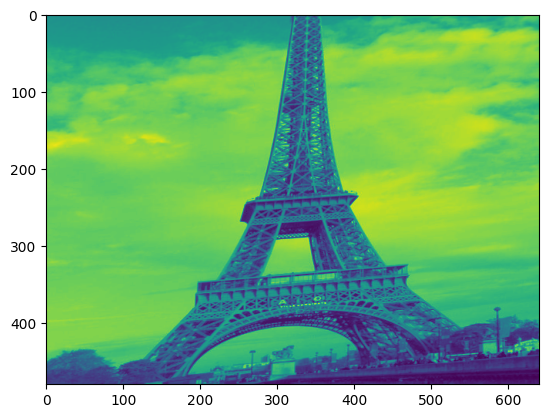

In [86]:

# path = 'data/mini_depth_100'
# image_path = 'data/mini_depth_100/138408872_2f903a81d4_o.jpg'
# generate sample homographies for images in path
from PIL import Image
import math

image_path1 = '/home/egoedeke/Downloads/MegaDepth_v1/phoenix/S6/zl548/MegaDepth_v1/0000/dense1/imgs/11037727_d36d4462ad_o.jpg'
image = Image.open(image_path)
width, height = image.size

# get image shape in h and w



conf = {
    "patch_shape": [640, 480],
    "difficulty": 0.5,
    "translation": 1.0,
    "n_angles": 10,
    "max_angle": 60,
    "min_convexity": 0.05,
}

img = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)

a = sample_homography(img, conf, [640, 480])

# visualize a
import matplotlib.pyplot as plt
plt.imshow(a['image'])
